In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql import functions as f

spark = SparkSession.builder.enableHiveSupport().getOrCreate()

# Suppresses user warinig messages in Python
import warnings
warnings.simplefilter("ignore", UserWarning)

# Suppresses `WARN` messages in JVM
spark.sparkContext.setLogLevel("ERROR")

NOTE: SPARK_PREPEND_CLASSES is set, placing locally compiled Spark classes ahead of assembly.
21/11/02 15:52:38 WARN Utils: Your hostname, maropus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.3.4 instead (on interface en0)
21/11/02 15:52:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/02 15:52:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import importlib
ptesting_model = importlib.import_module("ptesting-model")

In [3]:
expected_input_cols = [                                                                                                                                                                                                                       
    'author',
    'case when length(sha) > 0 then sha else sha(string(random())) end sha',
    'commit_date',
    'array_distinct(failed_tests) failed_tests',
    'files' 
]

log_data_df = spark.read.format('json').load('../models/spark/logs/github-logs.json').selectExpr(expected_input_cols)

In [4]:
log_data_df.orderBy(f.expr('commit_date').desc()).show(3)

+------------+--------------------+-------------------+--------------------+--------------------+
|      author|                 sha|        commit_date|        failed_tests|               files|
+------------+--------------------+-------------------+--------------------+--------------------+
|         c21|9b8b9ef7efa3ab055...|2021/10/26 23:36:54|                  []|[{{10, 10, 0, sql...|
|     xkrogen|bfb98833ddd60db80...|2021/10/26 22:16:21|                  []|[{{9, 18, 9, core...|
|AngersZhuuuu|d03a64cf0b4e5e303...|2021/10/26 14:17:48|[org.apache.spark...|[{{288, 288, 0, s...|
+------------+--------------------+-------------------+--------------------+--------------------+
only showing top 3 rows



In [5]:
import json
from pathlib import Path 
excluded_tests = json.loads(Path('../models/spark/logs/excluded-tests.json').read_text())
log_data_df = ptesting_model._exclude_tests_from(log_data_df, excluded_tests)

In [6]:
from ptesting import github_utils

test_files = json.loads(Path('../models/spark/indexes/latest/test-files.json').read_text())
commits = json.loads(Path('../models/spark/logs/commits.json').read_text())
commits = list(map(lambda c: github_utils.from_github_datetime(c[0]), commits))
updated_file_stats = json.loads(Path('../models/spark/logs/updated-file-stats.json').read_text())
failed_tests = json.loads(Path('../models/spark/failed-tests.json').read_text())
contributor_stats = json.loads(Path('../models/spark/logs/contributor-stats.json').read_text())
dep_graph = json.loads(Path('../models/spark/indexes/latest/dep-graph.json').read_text())

In [7]:
to_train_features, to_test_features = ptesting_model._create_train_test_pipeline(spark, test_files, commits, dep_graph, updated_file_stats, contributor_stats, failed_tests)

In [8]:
train_df, test_df = ptesting_model._train_test_split(log_data_df, test_ratio=0.10)

In [9]:
pdf = to_train_features(train_df).cache().toPandas()
pdf

,failed,num_commits,updated_num_3d,updated_num_14d,updated_num_56d,updated_num_3c,updated_num_14c,updated_num_56c,num_adds,num_dels,...,failed_num_7d__x__num_chgs,failed_num_7d__x__updated_num_56d,failed_num_7d__x__updated_num_56c,failed_num_7d__x__path_difference,failed_num_7d__x__distance,distance__x__num_commits,distance__x__num_chgs,distance__x__updated_num_56d,distance__x__updated_num_56c,distance__x__path_difference
0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,2,0,0,5
1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,2,0,0,4
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,2,0,0,5
3,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,4,0,0,8
4,0,0,0,0,0,0,0,0,27,27,...,0,0,0,0,0,0,54,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139169,1,634,0,3,17,0,0,3,58,20,...,78,17,3,3,1,634,78,17,3,3
139170,1,634,0,3,17,0,0,3,58,20,...,312,68,12,20,8,1268,156,34,6,10
139171,1,634,0,3,17,0,0,3,58,20,...,78,17,3,5,0,0,0,0,0,0
139172,1,221,0,3,43,0,0,2,155,87,...,484,86,4,12,6,663,726,129,6,18


In [10]:
pdf.dtypes

failed                                  int32
num_commits                             int32
updated_num_3d                          int32
updated_num_14d                         int32
updated_num_56d                         int32
updated_num_3c                          int32
updated_num_14c                         int32
updated_num_56c                         int32
num_adds                                int32
num_dels                                int32
num_chgs                                int32
file_card                               int32
failed_num_7d                           int32
failed_num_14d                          int32
failed_num_28d                          int32
failed_num_7c                           int32
failed_num_14c                          int32
failed_num_28c                          int32
total_failed_num                        int32
path_difference                         int32
distance                                int32
total_failed_num__x__num_commits  

In [11]:
test_feature_df = to_test_features(test_df).cache()
test_pdf = test_feature_df.toPandas()
test_pdf

2021-11-02 15:55:12.400 WARNING ptesting-model: to_test_features: expected unused features are [failed_tests]


,sha,test,num_commits,updated_num_3d,updated_num_14d,updated_num_56d,updated_num_3c,updated_num_14c,updated_num_56c,num_adds,...,failed_num_7d__x__num_chgs,failed_num_7d__x__updated_num_56d,failed_num_7d__x__updated_num_56c,failed_num_7d__x__path_difference,failed_num_7d__x__distance,distance__x__num_commits,distance__x__num_chgs,distance__x__updated_num_56d,distance__x__updated_num_56c,distance__x__path_difference
0,2e2283de4b77fd407935ff074e0f465b73cbc7c4,org.apache.spark.sql.hive.execution.HiveComman...,0,0,0,0,0,0,0,104,...,0,0,0,0,0,0,30464,0,0,896
1,2e2283de4b77fd407935ff074e0f465b73cbc7c4,org.apache.spark.sql.catalyst.expressions.Comp...,0,0,0,0,0,0,0,104,...,0,0,0,0,0,0,30464,0,0,1024
2,2e2283de4b77fd407935ff074e0f465b73cbc7c4,org.apache.spark.sql.HiveCharVarcharDDLTestSuite,0,0,0,0,0,0,0,104,...,0,0,0,0,0,0,30464,0,0,640
3,2e2283de4b77fd407935ff074e0f465b73cbc7c4,org.apache.spark.sql.hive.HiveUtilsSuite,0,0,0,0,0,0,0,104,...,0,0,0,0,0,0,30464,0,0,768
4,2e2283de4b77fd407935ff074e0f465b73cbc7c4,org.apache.spark.sql.connector.DataSourceV2Fun...,0,0,0,0,0,0,0,104,...,0,0,0,0,0,0,30464,0,0,768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89323,f16f2608195838310c0202fcbc0d15d4ac9269c5,org.apache.spark.sql.execution.command.v1.Drop...,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,5888,0,0,1408
89324,f16f2608195838310c0202fcbc0d15d4ac9269c5,org.apache.spark.graphx.lib.ShortestPathsSuite,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,5888,0,0,1152
89325,f16f2608195838310c0202fcbc0d15d4ac9269c5,org.apache.spark.ml.tuning.CrossValidatorSuite,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,5888,0,0,1024
89326,f16f2608195838310c0202fcbc0d15d4ac9269c5,pyspark.pandas.tests.indexes.test_category,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,5888,0,0,768


In [12]:
from ptesting import train

X = pdf[pdf.columns[pdf.columns != 'failed']]
y = pdf['failed']
X, y = train.rebalance_training_data(X, y, coeff=2.0)
pdf = X.copy(deep=True)
pdf['failed'] = y

2021-11-02 15:55:57.491 INFO train: Sampling training data (strategy={0: 1622, 1: 811}): {0: 138363, 1: 811} => {0: 1622, 1: 811}


In [13]:
X.describe()

,num_commits,updated_num_3d,updated_num_14d,updated_num_56d,updated_num_3c,updated_num_14c,updated_num_56c,num_adds,num_dels,num_chgs,...,failed_num_7d__x__num_chgs,failed_num_7d__x__updated_num_56d,failed_num_7d__x__updated_num_56c,failed_num_7d__x__path_difference,failed_num_7d__x__distance,distance__x__num_commits,distance__x__num_chgs,distance__x__updated_num_56d,distance__x__updated_num_56c,distance__x__path_difference
count,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,...,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2433.000000,2.433000e+03,2433.000000,2433.000000,2433.000000
mean,87.736539,2.711467,6.903822,14.200575,0.408960,0.614468,3.332922,1288.119605,178.681463,1466.801069,...,113.320592,6.914920,2.160707,1.813399,32.814221,3395.004110,1.060702e+04,704.943280,257.198109,163.054665
std,141.125930,3.922745,7.523305,13.114879,2.261673,2.376763,3.783205,10612.650360,801.667657,10790.772687,...,863.556508,12.649166,3.506700,5.750618,56.641939,7793.206154,7.416433e+04,1181.895738,445.795790,695.587880
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,48.000000,7.000000,55.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.200000e+02,0.000000,0.000000,7.000000
50%,0.000000,1.000000,4.000000,15.000000,0.000000,0.000000,2.000000,86.000000,12.000000,118.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.520000e+02,26.000000,4.000000,12.000000
75%,83.000000,8.000000,18.000000,20.000000,0.000000,0.000000,8.000000,199.000000,57.000000,308.000000,...,55.000000,20.000000,4.000000,3.000000,128.000000,10624.000000,7.040000e+03,2304.000000,256.000000,256.000000
max,887.000000,29.000000,29.000000,100.000000,29.000000,29.000000,29.000000,130829.000000,9386.000000,132030.000000,...,23384.000000,200.000000,16.000000,128.000000,384.000000,113536.000000,2.443264e+06,12800.000000,3200.000000,16384.000000


In [14]:
# import featuretools as ft
# es = ft.EntitySet(id='ptesting_model')
# es = es.entity_from_dataframe(entity_id='github_logs', dataframe=X, index='uid', make_index=True)
# X, _ = ft.dfs(entityset=es, target_entity='github_logs', trans_primitives=['multiply_numeric'], agg_primitives=[], max_depth=1)

In [15]:
def to_histogram_seaborn_numeirc_only(X):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    fig = plt.figure(figsize=(20, 16))
    return X.hist(ax=fig.gca())

array([[<AxesSubplot:title={'center':'num_commits'}>,
        <AxesSubplot:title={'center':'updated_num_3d'}>,
        <AxesSubplot:title={'center':'updated_num_14d'}>,
        <AxesSubplot:title={'center':'updated_num_56d'}>,
        <AxesSubplot:title={'center':'updated_num_3c'}>,
        <AxesSubplot:title={'center':'updated_num_14c'}>],
       [<AxesSubplot:title={'center':'updated_num_56c'}>,
        <AxesSubplot:title={'center':'num_adds'}>,
        <AxesSubplot:title={'center':'num_dels'}>,
        <AxesSubplot:title={'center':'num_chgs'}>,
        <AxesSubplot:title={'center':'file_card'}>,
        <AxesSubplot:title={'center':'failed_num_7d'}>],
       [<AxesSubplot:title={'center':'failed_num_14d'}>,
        <AxesSubplot:title={'center':'failed_num_28d'}>,
        <AxesSubplot:title={'center':'failed_num_7c'}>,
        <AxesSubplot:title={'center':'failed_num_14c'}>,
        <AxesSubplot:title={'center':'failed_num_28c'}>,
        <AxesSubplot:title={'center':'total_failed_nu

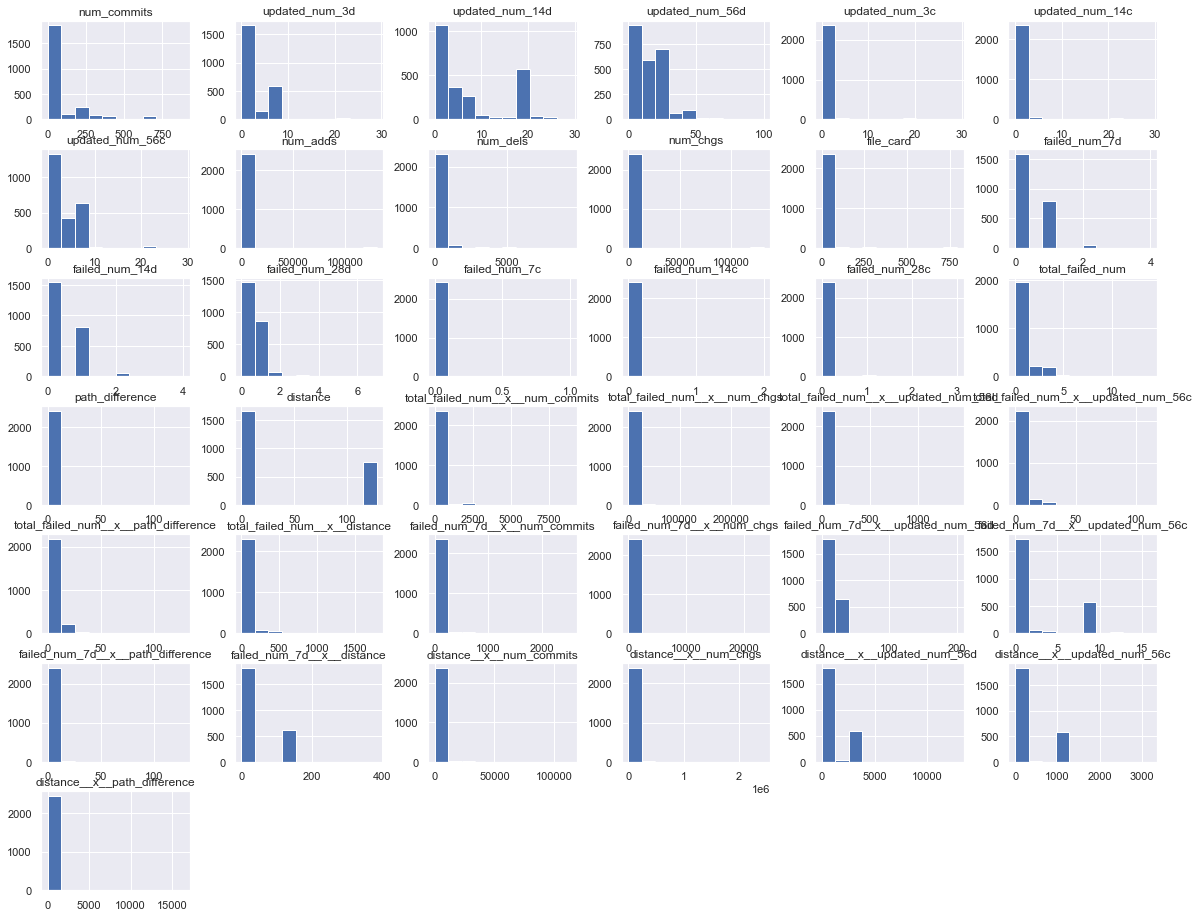

In [16]:
to_histogram_seaborn_numeirc_only(X)

In [17]:
def to_splom_altair(X, target):
    import altair as alt
    chart = alt.Chart(X).mark_circle().encode(
        alt.X(alt.repeat("column"), type='quantitative'),
        alt.Y(alt.repeat("row"), type='quantitative'),
        color=f'{target}:N'
    )
    chart = chart.properties(width=100, height=100)
    chart = chart.repeat(
        row=X.columns.tolist(),
        column=X.columns.tolist()
    )
    return chart

In [18]:
to_splom_altair(pdf, target='failed')

alt.RepeatChart(...)

In [19]:
def to_corr_heatmap(X):    
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure(figsize=(10, 8))
    return sns.heatmap(X.corr(method='pearson'), vmax=1, vmin=-1, center=0, ax=fig.gca())

<AxesSubplot:>

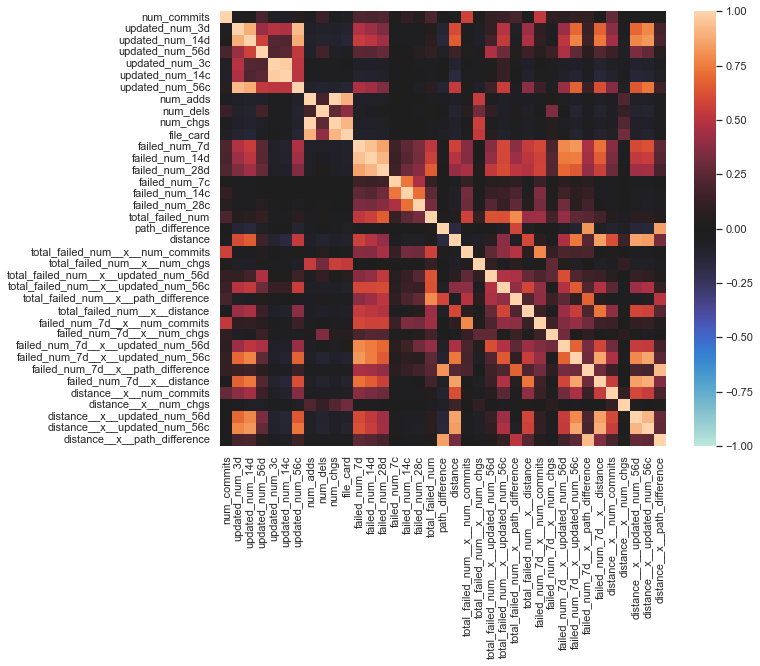

In [20]:
to_corr_heatmap(X)

In [21]:
def compute_mi_between_features(X):
    from minepy import MINE
    results = []
    mine = MINE(alpha=0.6, c=15, est="mic_approx")

    import itertools
    for c1, c2 in itertools.combinations(X.columns, 2):
        mine.compute_score(X[c1], X[c2])
        results.append(((c1, c2), mine.mic()))

    return sorted(results, key=lambda x: x[1], reverse=True)

In [22]:
mi_between_fts = compute_mi_between_features(X)
print(mi_between_fts[0:3])

[(('num_adds', 'num_chgs'), 0.9920052671506506), (('num_commits', 'distance__x__num_commits'), 0.9592949156331996), (('num_chgs', 'file_card'), 0.9530814300325638)]


In [23]:
def compute_mi_against(target, X):
    from minepy import MINE
    results = []
    mine = MINE(alpha=0.6, c=15, est="mic_approx")

    for c in X.columns:
        mine.compute_score(y, X[c])
        results.append(((target, c), mine.mic()))

    return sorted(results, key=lambda x: x[1], reverse=True)

In [24]:
mi_against_target = compute_mi_against('failed', X)
selected_features_with_mi = list(map(lambda x: x[0][1], mi_against_target))[0:16]
print(mi_against_target[0:3])

[(('failed', 'failed_num_7d__x__num_chgs'), 0.9042259939881506), (('failed', 'failed_num_7d__x__path_difference'), 0.8564469984385408), (('failed', 'failed_num_7d'), 0.8397243034760512)]


In [25]:
def select_features_with_bruta(X, y, is_discrete=True):
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
    from boruta import BorutaPy
    model_class = RandomForestClassifier if is_discrete else RandomForestRegressor
    rf = model_class(n_jobs=-1, max_depth=5)
    rf.fit(X, y)
    print('SCORE with ALL Features: %1.2f' % rf.score(X, y))

    rf = model_class(n_jobs=-1, max_depth=5)
    fs = BorutaPy(rf, n_estimators='auto', random_state=42, perc=80, two_step=False, max_iter=500)
    fs.fit(X.values, y.values)

    selected = fs.support_
    X_selected = X[X.columns[selected]]
    rf = model_class(n_jobs=-1, max_depth=5)
    rf.fit(X_selected, y)
    print('SCORE with selected Features: %1.2f' % rf.score(X_selected, y))
    
    return X.columns[selected]

In [26]:
selected_features_with_bruta = select_features_with_bruta(X, y, is_discrete=True)

SCORE with ALL Features: 1.00
SCORE with selected Features: 1.00


In [27]:
columns_selected = X.columns
# columns_selected = selected_features_with_bruta
# columns_selected = selected_features_with_mi
columns_selected

Index(['num_commits', 'updated_num_3d', 'updated_num_14d', 'updated_num_56d',
       'updated_num_3c', 'updated_num_14c', 'updated_num_56c', 'num_adds',
       'num_dels', 'num_chgs', 'file_card', 'failed_num_7d', 'failed_num_14d',
       'failed_num_28d', 'failed_num_7c', 'failed_num_14c', 'failed_num_28c',
       'total_failed_num', 'path_difference', 'distance',
       'total_failed_num__x__num_commits', 'total_failed_num__x__num_chgs',
       'total_failed_num__x__updated_num_56d',
       'total_failed_num__x__updated_num_56c',
       'total_failed_num__x__path_difference', 'total_failed_num__x__distance',
       'failed_num_7d__x__num_commits', 'failed_num_7d__x__num_chgs',
       'failed_num_7d__x__updated_num_56d',
       'failed_num_7d__x__updated_num_56c',
       'failed_num_7d__x__path_difference', 'failed_num_7d__x__distance',
       'distance__x__num_commits', 'distance__x__num_chgs',
       'distance__x__updated_num_56d', 'distance__x__updated_num_56c',
       'distance__x

In [28]:
X_selected = X[columns_selected]

In [29]:
def to_pca(X, y, target):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    _X = pca.fit_transform(X)
    _X = pd.DataFrame({'PCA-X': _X[:, 0], 'PCA-Y': _X[:, 1], target: y})

    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure(figsize=(10, 8))
    return sns.scatterplot(data=_X, x='PCA-X', y='PCA-Y', hue=target, ax=fig.gca())

<AxesSubplot:xlabel='PCA-X', ylabel='PCA-Y'>

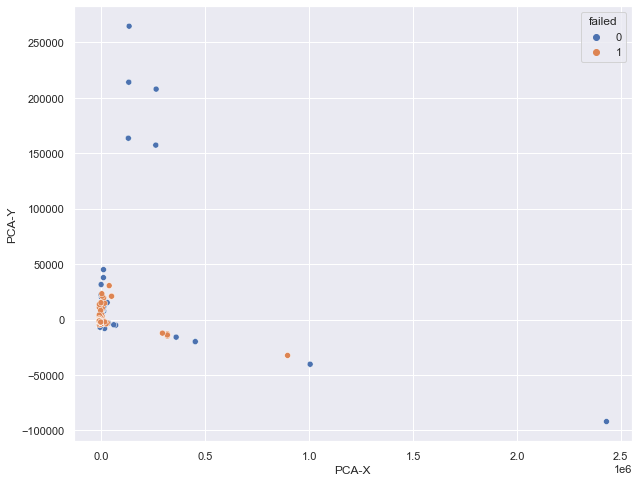

In [30]:
to_pca(X_selected, y, target='failed')

In [31]:
def to_tsne(X, y, target, nsample=100, perplexity=50, n_iter=10000):
    # One of non-linear embedding in sklearn
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=n_iter)
    _pdf = X.copy(deep=True)
    _pdf[target] = y
    _pdf_sampled = _pdf.sample(n=nsample, random_state=42)
    _X = _pdf_sampled[_pdf_sampled.columns[_pdf_sampled.columns != target]]
    _y = _pdf_sampled[target]
    _tf = tsne.fit_transform(_X)
    _X = pd.DataFrame({'tSNE-X': _tf[:, 0], 'tSNE-Y': _tf[:, 1], target: _y})
    print('KL divergence: {}'.format(tsne.kl_divergence_))

    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure(figsize=(10, 8))
    return sns.scatterplot(data=_X, x='tSNE-X', y='tSNE-Y', hue=target, ax=fig.gca())

KL divergence: 0.04883285239338875


<AxesSubplot:xlabel='tSNE-X', ylabel='tSNE-Y'>

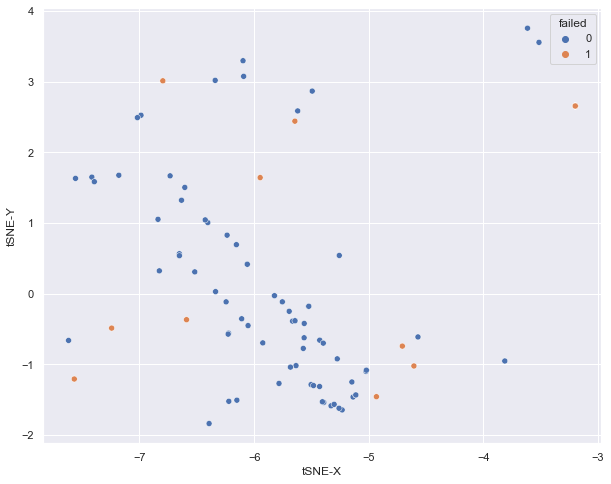

In [32]:
to_tsne(X_selected, y, target='failed', nsample=100, perplexity=50, n_iter=10000)

In [33]:
def to_umap(X, y, target, n_neighbors=5, min_dist=0.3, metric='euclidean'):
    from umap import UMAP
    umap = UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    _data = umap.fit_transform(X)
    _X = pd.DataFrame({'tSNE-X': _data[:, 0], 'tSNE-Y': _data[:, 1], target: y})

    import altair as alt
    chart = alt.Chart(_X).mark_point().encode(x='tSNE-X', y='tSNE-Y', color=f'{target}:N').properties(width=600, height=400).interactive()
    return chart

In [34]:
to_umap(X_selected, y, target='failed', n_neighbors=300, min_dist=1.0, metric='euclidean')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


alt.Chart(...)

In [35]:
def reduce_dim(X, y, target, n_components=2, n_neighbors=5, min_dist=0.3, metric='euclidean'):
    from umap import UMAP
    umap = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=42)
    _data = umap.fit_transform(X)
    _columns = list(map(lambda x: f'UMAP-{x}', range(0, n_components)))
    return pd.DataFrame(_data, columns=_columns), umap

In [36]:
# X_selected, _ = reduce_dim(X_selected, y, target='failed', n_components=18, n_neighbors=300, min_dist=1.0, metric='euclidean')

In [37]:
from ptesting import train
params = {'hp.timeout': '3600', 'hp.no_progress_loss': '0'}
clf, score = train.build_model(X_selected, y, opts=params)
print(f'Score: {score}')

Score: 0.9935595659681491


In [38]:
list(sorted(filter(lambda x: x[1] > 0.0, zip(clf.feature_name_, clf.feature_importances_)), key=lambda x: x[1], reverse=True))

[('failed_num_7d', 46870.364422529936),
 ('failed_num_7d__x__num_chgs', 22557.556074043736),
 ('failed_num_7d__x__updated_num_56d', 20485.40019387711),
 ('failed_num_7d__x__path_difference', 12615.598511960357),
 ('failed_num_7d__x__distance', 8798.614528134465),
 ('failed_num_28d', 7615.821539133787),
 ('failed_num_7d__x__num_commits', 4581.851856917143),
 ('failed_num_14d', 4447.548583984375),
 ('total_failed_num__x__updated_num_56d', 3490.8110288009048),
 ('failed_num_7d__x__updated_num_56c', 2952.198783606291),
 ('total_failed_num__x__path_difference', 1669.7883300688118),
 ('failed_num_28c', 1269.1018437743187),
 ('distance__x__updated_num_56d', 1173.7670992175117),
 ('distance__x__updated_num_56c', 1044.2868430949748),
 ('total_failed_num', 895.9246253073215),
 ('distance__x__path_difference', 806.3121420629323),
 ('total_failed_num__x__num_commits', 797.9280974902213),
 ('distance', 692.7631145715714),
 ('distance__x__num_commits', 617.2794614047743),
 ('updated_num_56d', 550.92

In [39]:
probs = clf.predict_proba(test_pdf[columns_selected])
pmf = map(lambda p: {"classes": clf.classes_.tolist(), "probs": p.tolist()}, probs)
pmf = map(lambda p: json.dumps(p), pmf)
df = spark.createDataFrame(pd.DataFrame({'sha': test_pdf['sha'], 'test': test_pdf['test'], 'pmf': list(pmf)}))
df = df.selectExpr('sha', 'test', 'from_json(pmf, "classes array<string>, probs array<double>") pmf')
df = df.selectExpr('sha', 'test', 'map_from_arrays(pmf.classes, pmf.probs) pmf')
df = df.selectExpr('sha', 'test', 'pmf["1"] failed_prob', 'pmf["1"] >= 0.50 predicted')
df = df.join(test_df, 'sha', 'INNER').selectExpr('sha', 'test', 'failed_prob', 'size(failed_tests) > 0 failed', 'predicted', 'failed_tests')

extract_test = 'transform(files.file.name, f -> replace(regexp_extract(f, "\/(org\/apache\/spark\/[a-zA-Z0-9/\-]+Suite)\.scala$", 1), "/", "."))'
updated_test_df = test_df.selectExpr('sha', f'filter({extract_test}, f -> length(f) > 0) updated_tests')
corrected_failed_prob = 'case when array_contains(updated_tests, test) then 1.0 else failed_prob end failed_prob'
df = df.join(updated_test_df, 'sha', 'INNER').selectExpr('sha', 'test', corrected_failed_prob, 'failed', 'predicted', 'failed_tests')

<AxesSubplot:>

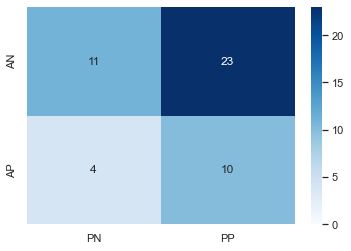

In [40]:
prob_thres = 0.50
predicted_pdf = df.groupBy('sha').agg(f.expr('first(failed) failed'), f.expr('array_max(collect_set(failed_prob)) failed_prob')).selectExpr('failed', f'failed_prob >= {prob_thres} predicted', 'failed_prob').toPandas()

import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predicted_pdf['failed'], predicted_pdf['predicted'])
sns.heatmap(pd.DataFrame(cm, index=['AN', 'AP'], columns=['PN', 'PP']), annot=True, cmap='Blues', vmin=0)

In [41]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(predicted_pdf['failed'], predicted_pdf['predicted'], target_names=['passed', 'failed'], output_dict=True))

,passed,failed,accuracy,macro avg,weighted avg
precision,0.733333,0.303030,0.4375,0.518182,0.607828
recall,0.323529,0.714286,0.4375,0.518908,0.437500
f1-score,0.448980,0.425532,0.4375,0.437256,0.442141
support,34.000000,14.000000,0.4375,48.000000,48.000000


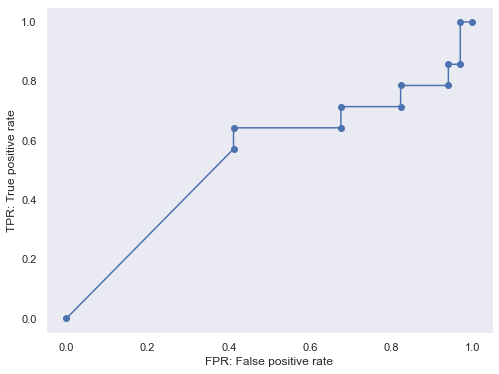

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

fpr, tpr, thres = roc_curve(predicted_pdf['failed'], predicted_pdf['failed_prob'])

sns.set()
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [43]:
rank_df = df.groupBy('sha').agg(f.expr('first(failed_tests) failed_tests'), f.expr('collect_set(named_struct("t", test, "p", failed_prob)) tests'))
rank_df = rank_df.selectExpr('sha', 'explode(failed_tests) failed_test', 'array_sort(tests, (l, r) -> case when l.p < r.p then 1 when l.p > r.p then -1 else 0 end) tests')
rank_df = rank_df.selectExpr('sha', 'failed_test', 'tests.t tests').selectExpr('sha', 'failed_test', 'array_position(tests, failed_test) rank')
rank_pdf = rank_df.toPandas()
rank_pdf

,sha,failed_test,rank
0,de0d183b72cf022cac2da1e860d2bd3f64e06d82,org.apache.spark.sql.SQLQueryTestSuite,5
1,de0d183b72cf022cac2da1e860d2bd3f64e06d82,org.apache.spark.sql.SubquerySuite,1314
2,de0d183b72cf022cac2da1e860d2bd3f64e06d82,org.apache.spark.sql.TPCDSQueryTestSuite,22
3,d03a64cf0b4e5e303c35acabab84315b9247b09b,org.apache.spark.sql.hive.execution.HiveUDAFSuite,919
4,d03a64cf0b4e5e303c35acabab84315b9247b09b,org.apache.spark.sql.hive.execution.HiveWindow...,28
...,...,...,...
139,9d0ea390f0b1b944ddf7b674b0ba553226daaedc,org.apache.spark.sql.SQLQuerySuite,20
140,9d0ea390f0b1b944ddf7b674b0ba553226daaedc,org.apache.spark.sql.expressions.ExpressionInf...,1314
141,a1f8e92ee6171fe2c7eadb24443e55386cb8ee56,org.apache.spark.sql.hive.execution.HashAggreg...,532
142,89fc1c0ac2d529972193e9feed1f35e8a93da00a,org.apache.spark.sql.hive.thriftserver.ThriftS...,126


In [44]:
coverage = []
num_rank_df = rank_df.count()
for t in [250, 500, 750, 1000]:
    coverage.append(rank_df.where(f'rank < {t}').count() / num_rank_df)
    
print(coverage)

[0.375, 0.5763888888888888, 0.8263888888888888, 0.9236111111111112]


Text(0, 0.5, 'Cumulative ratio')

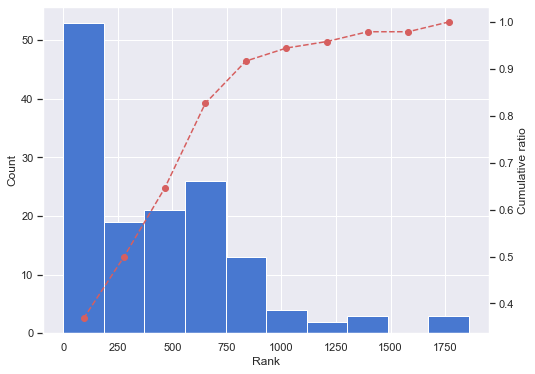

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid", palette="muted", color_codes=True)

fig, ax1 = plt.subplots(figsize=(8, 6))
n, bins, patches = ax1.hist(rank_pdf['rank'])
ax1.set_xlabel("Rank")
ax1.set_ylabel("Count")

ax2 = ax1.twinx()
y2 = np.add.accumulate(n) / n.sum()
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
lines = ax2.plot(x2, y2, ls='--', color='r', marker='o')
ax2.grid(visible=False)
ax2.set_ylabel('Cumulative ratio')

In [46]:
failed_tests['org.apache.spark.sql.jdbc.v2.DB2IntegrationSuite']

['2021/10/12 20:22:02',
 '2021/10/11 20:22:02',
 '2021/10/10 20:22:02',
 '2021/06/30 20:22:02']

In [47]:
def compute_distance(src, dst):
    visited_nodes = set()
    keys = list([src])
    for i in range(0, 16):
        if len(keys) == 0:
            return -1

        next_keys = set()
        for key in keys:
            if key in dep_graph and key not in visited_nodes:
                nodes = dep_graph[key]
                next_keys.update(nodes)
        if dst in next_keys:
            return i + 1

        visited_nodes.update(keys)
        keys = list(next_keys)

    return -1

In [48]:
compute_distance(src='org.apache.spark.sql.execution.datasources.jdbc.JDBCRDD', dst='org.apache.spark.sql.jdbc.v2.OracleIntegrationSuite')
# compute_distance(src='org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils', dst='org.apache.spark.sql.execution.datasources.jdbc.JDBCRDD')

1

In [51]:
target_sha = '305dacf51ce7bf39f93a2e0ba97960afdb3034d1'
# test_df.where(f'sha = "{target_sha}"').toPandas().to_dict(orient='records')
test_feature_df.join(df, ['sha', 'test'], 'INNER').where(f'sha == "{target_sha}" AND array_contains(failed_tests, test) and test == "org.apache.spark.sql.jdbc.v2.DB2IntegrationSuite"').toPandas().to_dict(orient='records')

[{'sha': '305dacf51ce7bf39f93a2e0ba97960afdb3034d1',
  'test': 'org.apache.spark.sql.jdbc.v2.DB2IntegrationSuite',
  'num_commits': 0,
  'updated_num_3d': 2,
  'updated_num_14d': 5,
  'updated_num_56d': 9,
  'updated_num_3c': 0,
  'updated_num_14c': 2,
  'updated_num_56c': 4,
  'num_adds': 26,
  'num_dels': 26,
  'num_chgs': 52,
  'file_card': 7,
  'failed_num_7d': 3,
  'failed_num_14d': 3,
  'failed_num_28d': 3,
  'failed_num_7c': 0,
  'failed_num_14c': 1,
  'failed_num_28c': 3,
  'total_failed_num': 4,
  'path_difference': 2,
  'distance': 1,
  'total_failed_num__x__num_commits': 0,
  'total_failed_num__x__num_chgs': 208,
  'total_failed_num__x__updated_num_56d': 36,
  'total_failed_num__x__updated_num_56c': 16,
  'total_failed_num__x__path_difference': 8,
  'total_failed_num__x__distance': 4,
  'failed_num_7d__x__num_commits': 0,
  'failed_num_7d__x__num_chgs': 156,
  'failed_num_7d__x__updated_num_56d': 27,
  'failed_num_7d__x__updated_num_56c': 12,
  'failed_num_7d__x__path_differ

In [50]:
import json
tdf = rank_df.join(test_df, 'sha', 'INNER').selectExpr('sha', 'rank', 'failed_test', 'files.file.name filenames').orderBy(f.expr('rank').desc()).toPandas()
print(json.dumps(tdf.to_dict(orient='records'), indent=2))

[
  {
    "sha": "305dacf51ce7bf39f93a2e0ba97960afdb3034d1",
    "rank": 1860,
    "failed_test": "org.apache.spark.sql.jdbc.v2.OracleIntegrationSuite",
    "filenames": [
      "external/docker-integration-tests/src/test/scala/org/apache/spark/sql/jdbc/v2/V2JDBCTest.scala",
      "sql/core/src/main/scala/org/apache/spark/sql/execution/datasources/jdbc/JDBCRDD.scala",
      "sql/core/src/main/scala/org/apache/spark/sql/execution/datasources/jdbc/JdbcUtils.scala",
      "sql/core/src/test/scala/org/apache/spark/sql/execution/datasources/v2/jdbc/JDBCTableCatalogSuite.scala",
      "sql/core/src/test/scala/org/apache/spark/sql/jdbc/JDBCSuite.scala",
      "sql/core/src/test/scala/org/apache/spark/sql/jdbc/JDBCV2Suite.scala",
      "sql/core/src/test/scala/org/apache/spark/sql/jdbc/JDBCWriteSuite.scala"
    ]
  },
  {
    "sha": "305dacf51ce7bf39f93a2e0ba97960afdb3034d1",
    "rank": 1859,
    "failed_test": "org.apache.spark.sql.jdbc.v2.PostgresIntegrationSuite",
    "filenames": [
      